# NimbusML Column Selection Syntax - Flight Schedule

In this example, we will present the column syntax introduced by nimbusml. While buiding the pipeline, users are allowed to introduce different transformations executing on different columns sequentially. Very similar to buiding deep learning models, the users can add "layer" after "layers" by indicating the input and output (column) names for each operator to avoid confusion. The computation graph can be clearly visualized.

The problem we are solving in this example is a binary classificaiton to predict if the flight will be delayed. The training/testing data was manually created.

In [1]:
import time
import pandas as pd
import numpy as np
from IPython.display import display,IFrame,Image
from nimbusml.feature_extraction.categorical import OneHotVectorizer
from nimbusml.ensemble import LightGbmBinaryClassifier
from nimbusml.preprocessing import missing_values
from nimbusml.preprocessing.schema import ColumnConcatenator
from nimbusml import Pipeline, FileDataStream 
from nimbusml.datasets import get_dataset

In this tutorial, we create the model using nimbusml pipelines trained with nimbusml FileDataStream.

## Loading Data

In [2]:
# Getting data file path        
train_file = get_dataset('fstrain').as_filepath()
test_file = get_dataset('fstest').as_filepath()

The input data consists of both categorical variables ('UniqueCarrier', 'Origin', 'Dest') and numeric variables ('Month', 'DayOfMonth', 'DayOfWeek', 'DepTime', 'Distance', 'DepDelay').

|Month|DayOfMonth|DayOfWeek|DepTime|Distance|UniqueCarrier|Origin|Dest|DepDelay|Label|
|-----|----------|---------|-------|--------|-------------|------|----|--------|-----|
|1|2|2|1525|293|WN|DAL|LBB|12|0|
|1|2|2|940|192|WN|HOU|SAT|-4|0|
|1|2|2|700|1044|WN|MCI|PHX|0|0|

We hope to:
    1. Applying missing_values.Handler to "UniqueCarrier"
    2. Applying OneHotVectorizer to all raw categorical columns, including column "UniqueCarrier" after step (1)
    3. Applying missing_values.Handler to all numeric features, i.e. ("Month", "DayOfMonth", "DayOfWeek", "DepTime", "Distance", "DepDelay").

The following figure indicates the above steps. Each item corresponds to a column and the arrow transformation/learner.

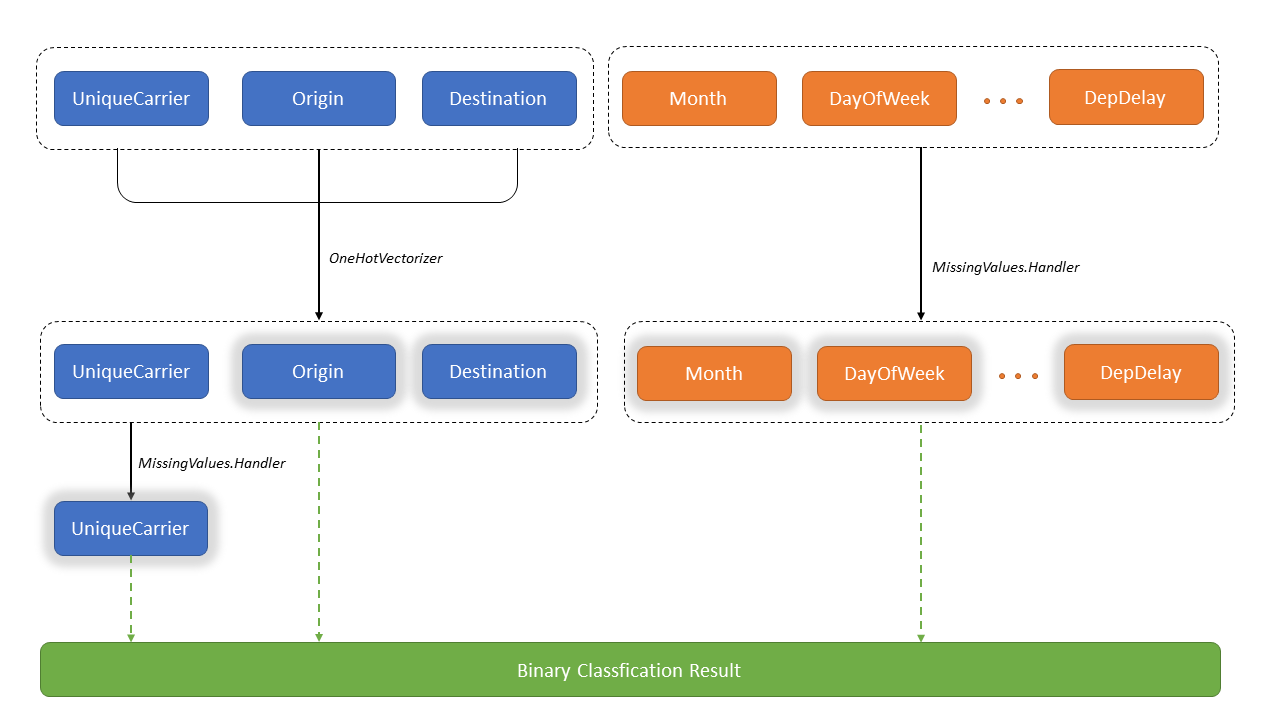

In [3]:
display(Image(filename='images/FDFigure.png')) #TO DO: REPLACE WITH GRAPH GENERATOR

Using the new nimbusml column syntax, a pipeline described in the above figure can be easily implemented. Users can define the input/output column names for each operator using **columns = {"output_column_name": "input_column_name(s)"}** or the new syntax "<<".

## Training

In [4]:
categorical_columns = ['UniqueCarrier', 'Origin', 'Dest']
numeric_columns = ['Month', 'DayOfMonth', 'DayOfWeek', 'DepTime', 'Distance', 'DepDelay']

ppl = Pipeline([
                    OneHotVectorizer(columns = categorical_columns),
                    missing_values.Handler(columns = {'UniqueCarrier_Handler':'UniqueCarrier'}),    
                    missing_values.Handler(columns = numeric_columns),  

                    # After the feature transformation, we add a LightGbm learner.
                    LightGbmBinaryClassifier(feature = categorical_columns + numeric_columns + ['UniqueCarrier_Handler'],
                                             label = 'Label') 
                ])

### Syntax for Transform: Dictionary

When initializing a transform, the users can specify both the input and the output column names for the execution. For instance, 

                    missing_values.Handler(columns = {'UniqueCarrier_Handler':'UniqueCarrier'})
or
                    
                    missing_values.Handler() << {'UniqueCarrier_Handler':'UniqueCarrier'}

indicates that:
1. The missing_values.Handler will select column "UniqueCarrier" for the execution, i.e. **input = 'UniqueCarrier'**
2. The transformed data will be saved to a new column named "UniqueCarrier_Handler", i.e. **output = 'UniqueCarrier_Handler'**

Notice that, in most cases, we don't allow a dictionary with a string as key and list as value, such as {"num_features": numeric_columns}, except for ColumnConcatenator, which concatenates multiple columns into a new column. 

After this transform, in addition to the origin columns in the input dataset, a new column named "UniqueCarrier_Handler" will be generated. If user specifies the same output name as the input, the column will be overwritten.

One special feature of nimbusml is that columns are allowed to include an array (vector) instead of one single value. For instance, a dataset with three columns in nimbusml may look like:

|Month,DayOfMonth,DayOfWeek|Origin,Dest|Features|
|----------------------------|-------------|----------|
|1,2,2,1525,293            |WN,DAL     |12,0    |
|1,2,2,940,192             |WN,HOU     |-4,0    |
|1,2,2,700,1044            |WN,MCI     |0,0     |

In this sense, the output(s) from OneHotVectorizer(columns = ["UniqueCarrier"]) are concatenated into one column named "UniqueCarrier" with vectors, e.g. [0,0,0,1]. The output with vector values can be further used in the next step with its column name as input.

Note: In nimbusml, some transformations, such as ColumnDropper, don't allow renaming, as there are no new columns being generated. In that case, dictionary is not allowed. A few transformations need more than two columns to generate a new column, such as ColumnConcatenator, a dictionary with list as values will be allowed, e.g. {'new_col':[concate_col1, concate_col2]}. For more details about the usage of each transformation, please refer to the documentation for API. 

### Syntax for Transform: List

Users can also specify the column names using a list. For instance,

                    OneHotVectorizer(columns = ['UniqueCarrier', 'Origin', 'Dest'])
indicates that:
1. The OneHotVectorizer will select columns ['UniqueCarrier', 'Origin', 'Dest'] for the execution, i.e. **input = ['UniqueCarrier', 'Origin', 'Dest']**
2. The transformed data will be saved to the same column with the same name (overwrite the origin input columns).

For case 2, all the output columns will have the same names as the input, i.e. replacing the input columns in the origin data frame. Thus, the above syntax is equivalent to:

            OneHotVectorizer(columns = {'UniqueCarrier':'UniqueCarrier' , 'Origin':'Origin', 'Dest':'Dest'})

For each operator, just like creating a neural network, the input and output is specified in a dictionary/list. If the input column names are not specified, all the input columns from previous transformation will be used. 

### Syntax for Learner: Role

For most learners, nimbusml introduces a class **Role**. Users can specify the roles for different columns in the column syntax using a dictionary, for example:

        from nimbusml import Role
        LightGbmBinaryClassifier(columns = {Role.Feature: categorical_columns + numeric_columns, Role.Label:'Label'})
            
or

            LightGbmBinaryClassifier(feature = categorical_columns + numeric_columns, label = 'Label')

Indicates that the input features for LightGbmBinaryClassifier are columns  categorical_columns + numeric_columns, and the label column is the column named 'Label'. Other roles are Role.GroupId, Role.Weight, etc.. If the label role was specified, user can use ppl.fit(data) directly without setting the y. 

In [5]:
# Creating FileDataStream
data_stream_train = FileDataStream.read_csv(train_file, sep=',', numeric_dtype=np.float32)
data_stream_test = FileDataStream.read_csv(test_file, sep=',', numeric_dtype=np.float32)

In [6]:
# Training with nimbusml file stream
%timeit ppl.fit(data_stream_train) 

Not adding a normalizer.
Auto-tuning parameters: UseCat = False
Auto-tuning parameters: LearningRate = 0.2
Auto-tuning parameters: NumLeaves = 20
Auto-tuning parameters: MinDataPerLeaf = 20
LightGBM objective=binary
Not training a calibrator because it is not needed.
Elapsed time: 00:00:03.7730095
Not adding a normalizer.
Auto-tuning parameters: UseCat = False
Auto-tuning parameters: LearningRate = 0.2
Auto-tuning parameters: NumLeaves = 20
Auto-tuning parameters: MinDataPerLeaf = 20
LightGBM objective=binary
Not training a calibrator because it is not needed.
Elapsed time: 00:00:02.7034011
Not adding a normalizer.
Auto-tuning parameters: UseCat = False
Auto-tuning parameters: LearningRate = 0.2
Auto-tuning parameters: NumLeaves = 20
Auto-tuning parameters: MinDataPerLeaf = 20
LightGBM objective=binary
Not training a calibrator because it is not needed.
Elapsed time: 00:00:02.5283012
Not adding a normalizer.
Auto-tuning parameters: UseCat = False
Auto-tuning parameters: LearningRate = 

## Testing

Similarly, we can call pipeline.test() to generate prediction and performance metrics.

In [7]:
# Testing using file stream
%time metrics, scores = ppl.test(data_stream_test,"Label", output_scores = True) 

print("Prediction for first 5 rows:")
display(scores[0:5])

print("Evaluation of the model using .test(): ")
display(metrics)

Wall time: 1.86 s
Prediction for first 5 rows:


,PredictedLabel,Probability,Score
0,0.0,0.000176,-17.291693
1,0.0,0.000172,-17.333096
2,0.0,0.000168,-17.378891
3,0.0,0.000175,-17.305880
4,0.0,0.000171,-17.343319


Evaluation of the model using .test(): 


,AUC,Accuracy,Positive precision,Positive recall,Negative precision,Negative recall,Log-loss,Log-loss reduction,Test-set entropy (prior Log-Loss/instance),F1 Score,AUPRC
0,0.754464,0.86,0.75,0.1875,0.864583,0.988095,1.739584,-174.248426,0.63431,0.3,0.337565
